In [20]:
import cv2
import os
import numpy as np
from keras.models import load_model, Model
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

In [21]:
def get_model(layer='fc2'):
    """Keras Model of the VGG16 network, with the output layer set to `layer`.
    The default layer is the second-to-last fully connected layer 'fc2' of
    shape (4096,).
    Parameters
    ----------
    layer : str
        which layer to extract (must be of shape (None, X)), e.g. 'fc2', 'fc1'
        or 'flatten'
    """
    # base_model.summary():
    #     ....
    #     block5_conv4 (Conv2D)        (None, 15, 15, 512)       2359808
    #     _________________________________________________________________
    #     block5_pool (MaxPooling2D)   (None, 7, 7, 512)         0
    #     _________________________________________________________________
    #     flatten (Flatten)            (None, 25088)             0
    #     _________________________________________________________________
    #     fc1 (Dense)                  (None, 4096)              102764544
    #     _________________________________________________________________
    #     fc2 (Dense)                  (None, 4096)              16781312
    #     _________________________________________________________________
    #     predictions (Dense)          (None, 1000)              4097000
    #
    base_model = VGG16(weights='imagenet', include_top=True)
    model = Model(inputs=base_model.input,
                outputs=base_model.get_layer(layer).output)
    return model

In [22]:
n = 256

a = np.linspace(-50, 50, n)
x, y = np.meshgrid(a, a)

k = np.fft.fftfreq(n, a[1]-a[0])
kx, ky = np.meshgrid(k, k)

def Gaussian(sigma):
    return np.exp(-0.5 * (x*x + y*y) / (sigma * sigma))

def noise(alpha):
    white_noise = np.random.rand(n, n)-0.5 + 1j*(np.random.rand(n, n)-0.5)
    power_law = np.power(kx*kx + ky*ky + 1e-300, -0.5 * alpha)
    power_law[0,0] = 0
    img  = np.real(np.fft.ifft2(white_noise * power_law))
    img += np.min(img)
    img /= np.max(img)
    return img

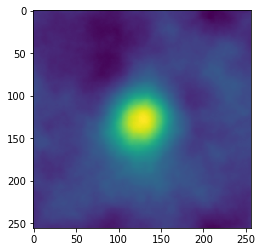

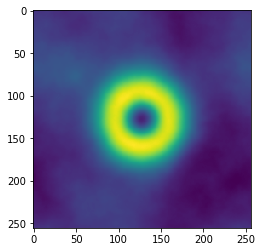

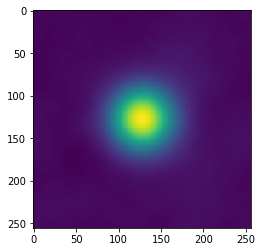

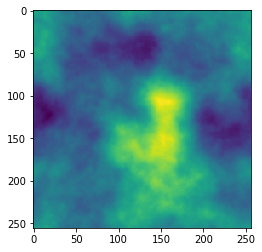

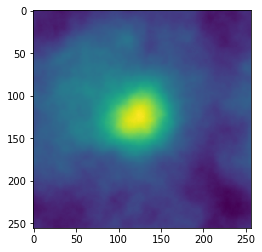

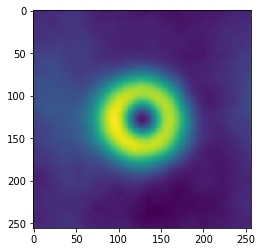

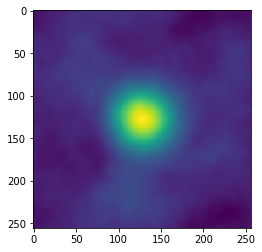

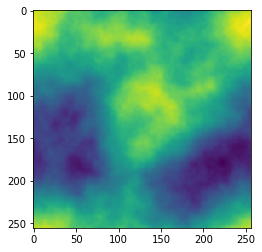

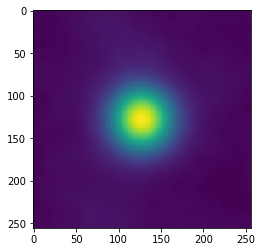

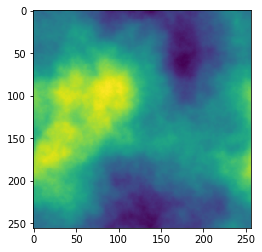

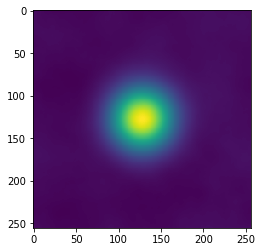

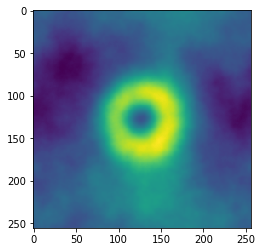

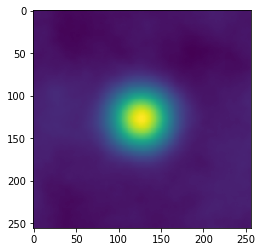

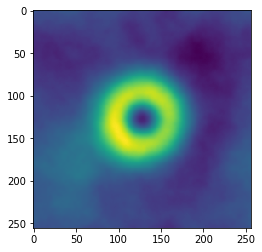

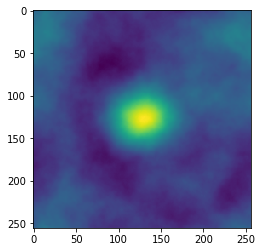

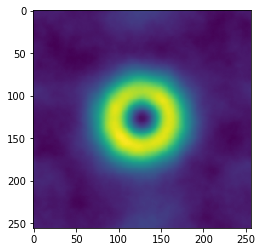

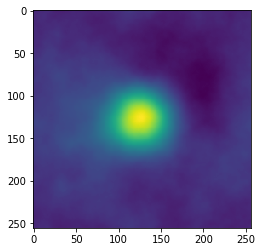

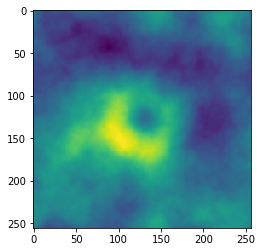

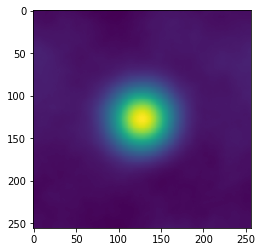

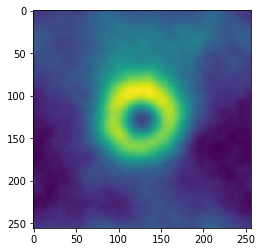

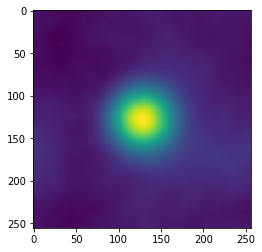

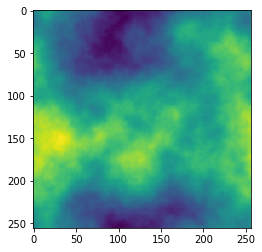

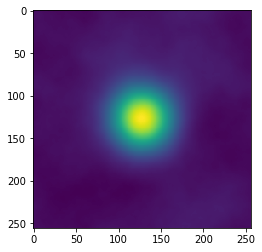

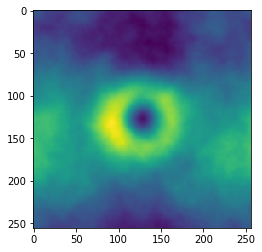

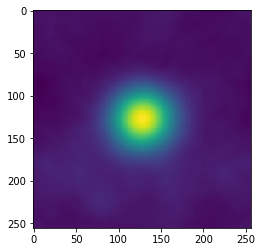

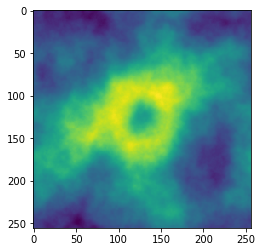

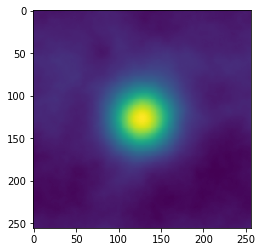

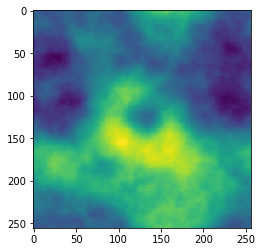

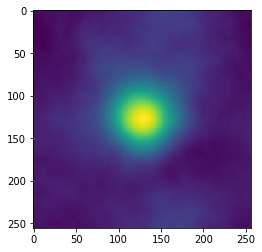

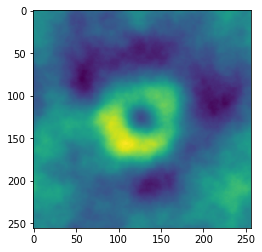

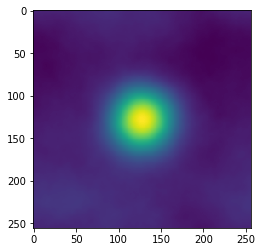

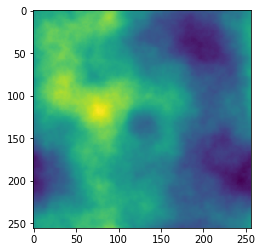

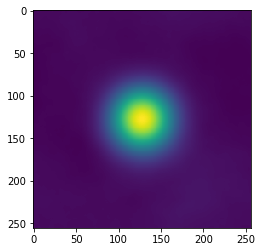

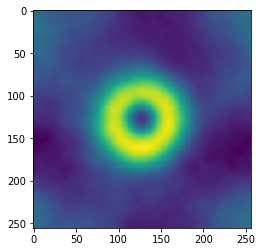

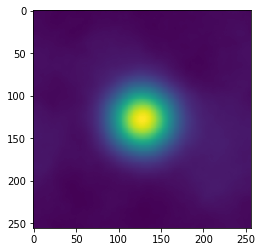

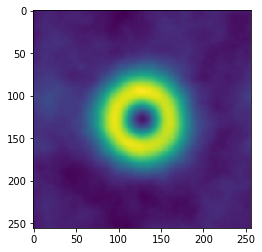

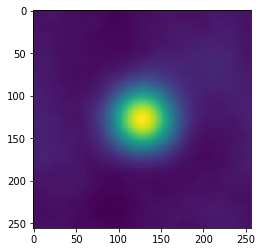

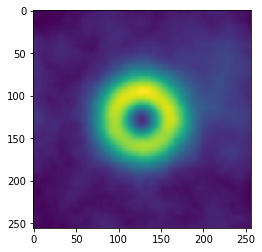

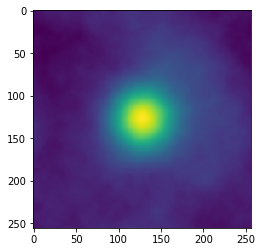

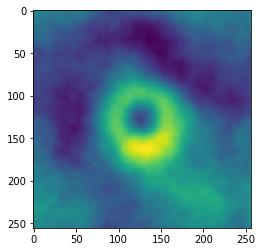

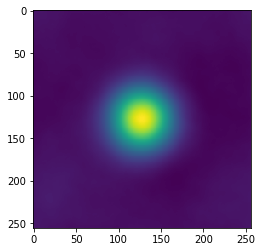

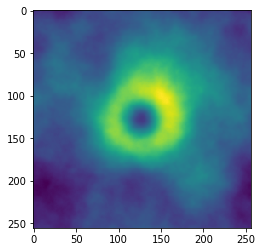

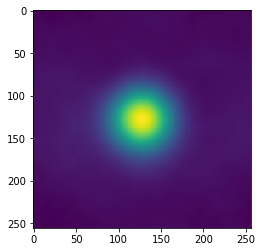

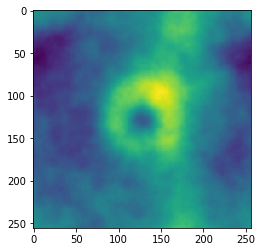

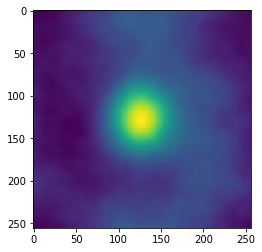

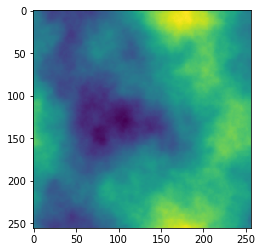

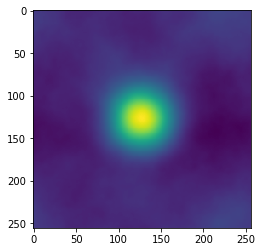

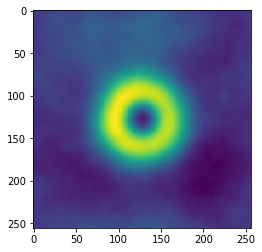

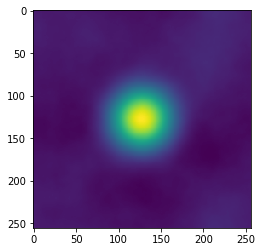

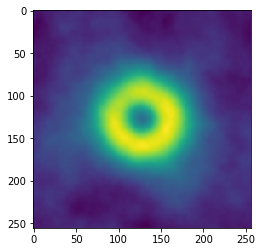

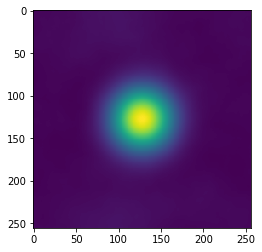

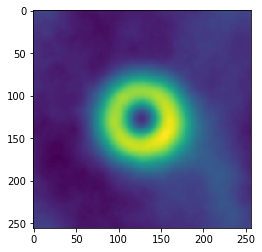

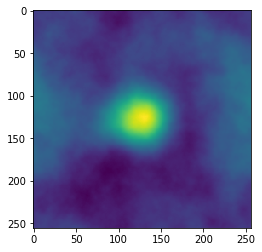

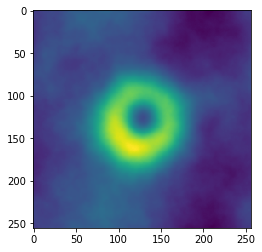

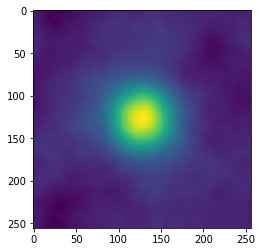

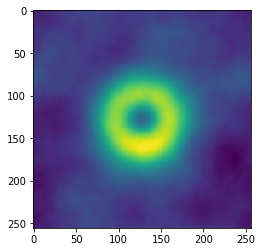

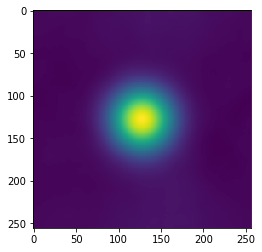

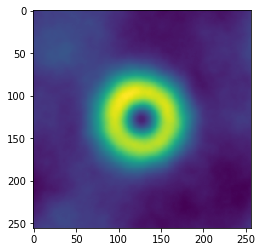

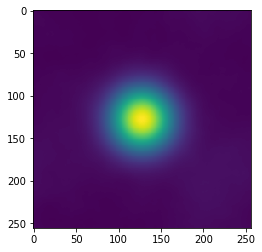

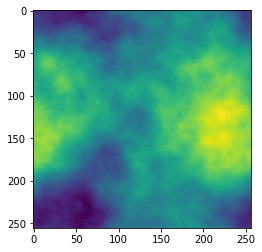

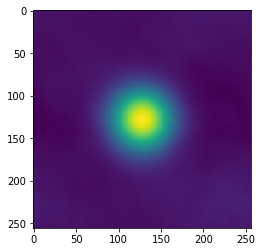

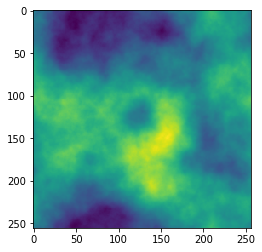

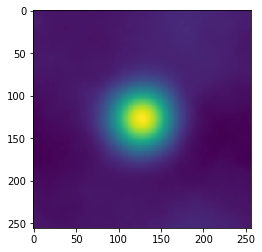

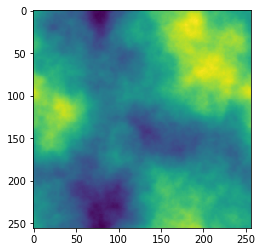

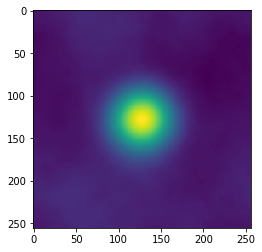

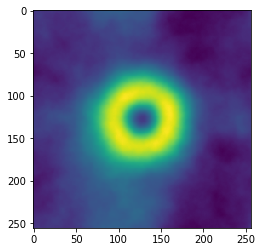

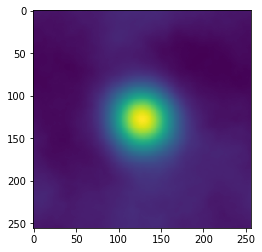

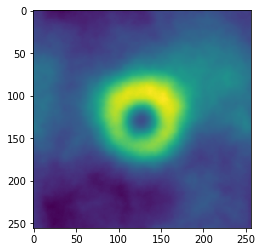

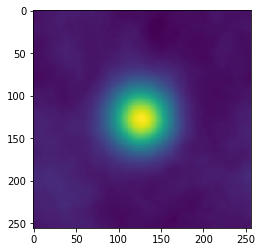

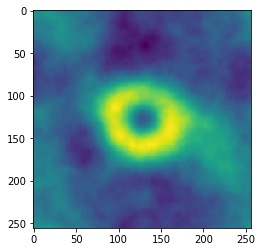

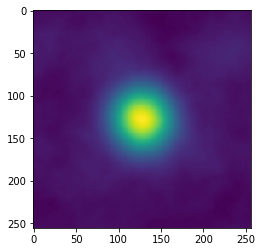

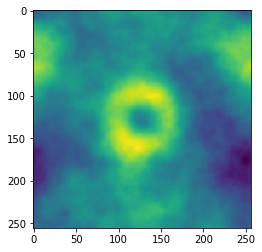

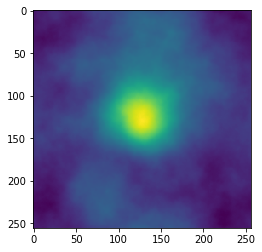

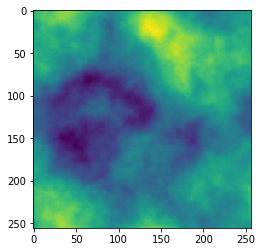

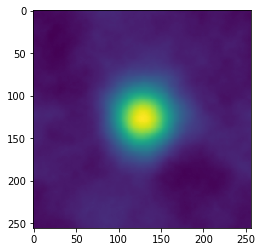

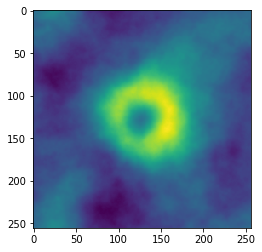

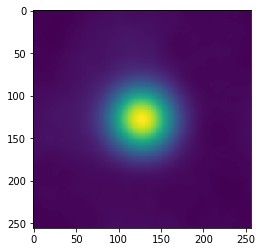

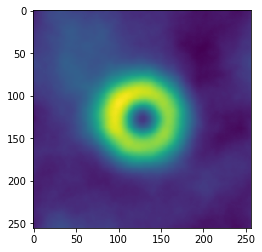

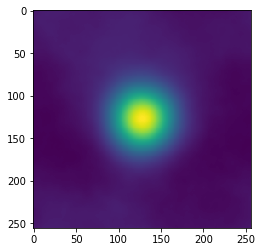

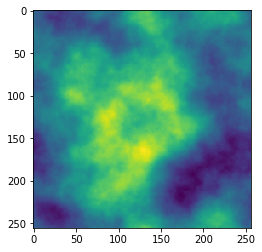

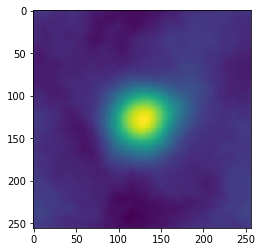

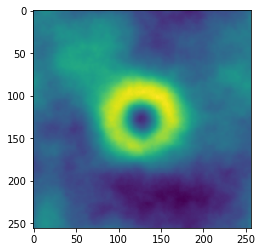

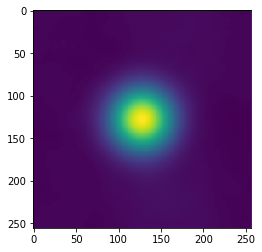

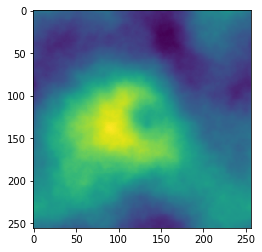

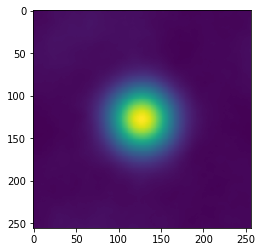

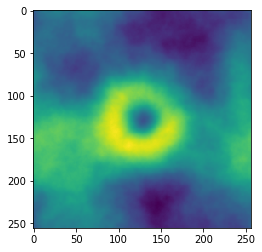

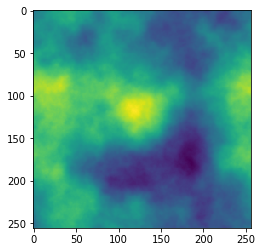

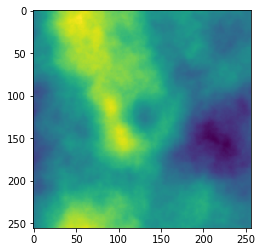

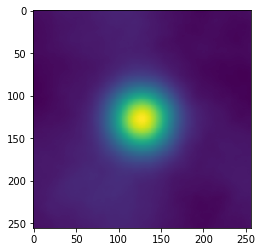

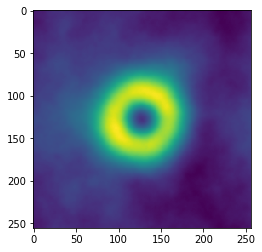

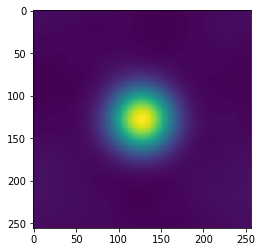

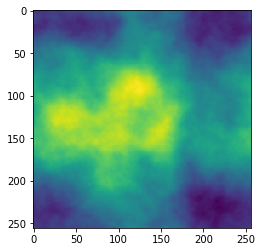

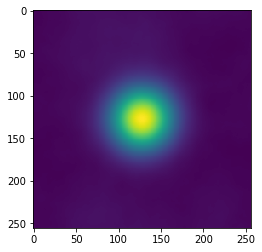

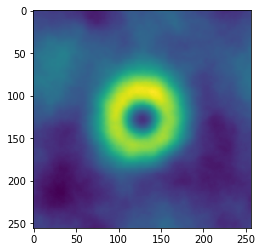

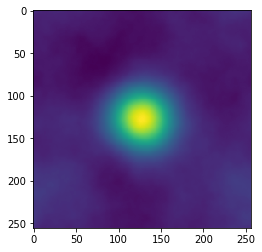

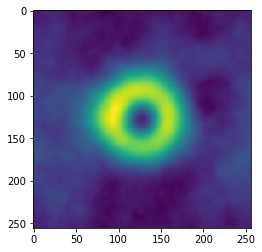

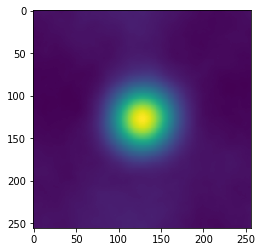

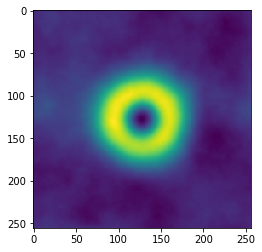

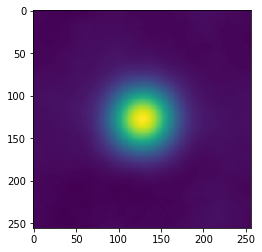

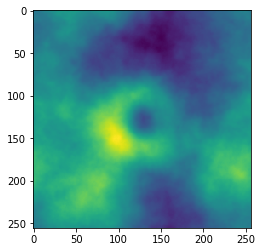

<Figure size 432x288 with 0 Axes>

In [23]:

data = []
for i in range(100):
    blob = Gaussian(10) + 0.01 * noise(2)   
    ring = Gaussian(10) - Gaussian(8) + 0.01 * noise(2)
    data.append(blob)
    data.append(ring)
    plt.imshow(data[i])
    plt.show()
    fig=plt.gcf()
    #plt.show()
    #fig.savefig('data/data_{0}.jpg'.format(i))
    plt.imsave('data/data_{0}.jpg'.format(i),data[i])

# Save to a file
#plt.savefig('data.jpg', format='jpg')

In [5]:
#dict(data)

In [24]:
def get_files(path_to_files, size):
    fn_imgs = []
    files = [file for file in os.listdir(path_to_files)]
    for file in files:
        img = cv2.resize(cv2.imread(path_to_files+file), size)
        fn_imgs.append([file, img])
    return dict(fn_imgs)

In [25]:
def feature_vector(img_arr, model):
    if img_arr.shape[2] == 1:
        img_arr = img_arr.repeat(3, axis=2)

        # (1, 224, 224, 3)
    arr4d = np.expand_dims(img_arr, axis=0)  
    arr4d_pp = preprocess_input(arr4d)
    return model.predict(arr4d_pp)[0,:]

In [26]:
def feature_vectors(imgs_dict, model):
    f_vect = {}
    for fn, img in imgs_dict.items():
        f_vect[fn] = feature_vector(img, model)
    return f_vect

In [27]:
imgs_dict = get_files(path_to_files = 'C:/Users/hewyu/Downloads/Clustering EHT images/data/',size = (224, 224))

# Create Keras NN model.
model = get_model()

# Feed images through the model and extract feature vectors.
img_feature_vector = feature_vectors(imgs_dict, model)

In [28]:
data[0]

array([[0.1650831 , 0.16860472, 0.16905393, ..., 0.14511837, 0.15313365,
        0.15950998],
       [0.16470591, 0.16883086, 0.17123312, ..., 0.14436771, 0.15182755,
        0.15882588],
       [0.16648487, 0.17019646, 0.17298116, ..., 0.14887984, 0.15287114,
        0.16095489],
       ...,
       [0.16629936, 0.17235092, 0.17320824, ..., 0.14670811, 0.15568516,
        0.1613727 ],
       [0.16663647, 0.17175569, 0.17366296, ..., 0.14577329, 0.15458114,
        0.16216888],
       [0.16743203, 0.17190615, 0.17187609, ..., 0.14655073, 0.15499285,
        0.16285239]])

Elbow Method 

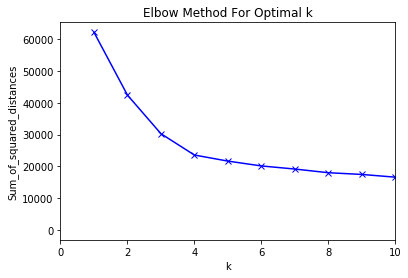

In [30]:
images = list(img_feature_vector.values())
fns = list(img_feature_vector.keys())
sum_of_squared_distances = []
K = range(1, 100)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(images)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xlim(0,10)
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(images)
y_kmeans = kmeans.predict(images)
file_names = list(imgs_dict.keys())

In [32]:
n_clusters = 4
cluster_path = 'C:/Users/hewyu/Downloads/Clustering EHT images/'
path_to_files = 'C:/Users/hewyu/Downloads/Clustering EHT images/data/'

for c in range(0,n_clusters):
    if not os.path.exists(cluster_path+'cluster_'+str(c)):
        os.mkdir(cluster_path+'cluster_'+str(c))
    
for fn, cluster in zip(file_names, y_kmeans):
    image = cv2.imread(path_to_files+fn)
    cv2.imwrite(cluster_path+'cluster_'+str(cluster)+'/'+fn, image)

In [37]:
print(kmeans.labels_)

[3 2 0 2 0 2 3 2 3 1 0 2 0 3 1 0 1 0 1 3 1 3 1 1 3 1 0 2 0 2 0 2 3 1 3 0 1
 0 1 3 1 3 2 0 2 2 0 2 3 3 3 2 0 2 0 1 3 0 1 0 1 0 2 0 2 3 1 1 0 1 3 1 3 1
 0 2 0 1 0 3 2 0 1 0 1 1 1 0 2 1 0 1 0 2 3 2 0 2 0 1]


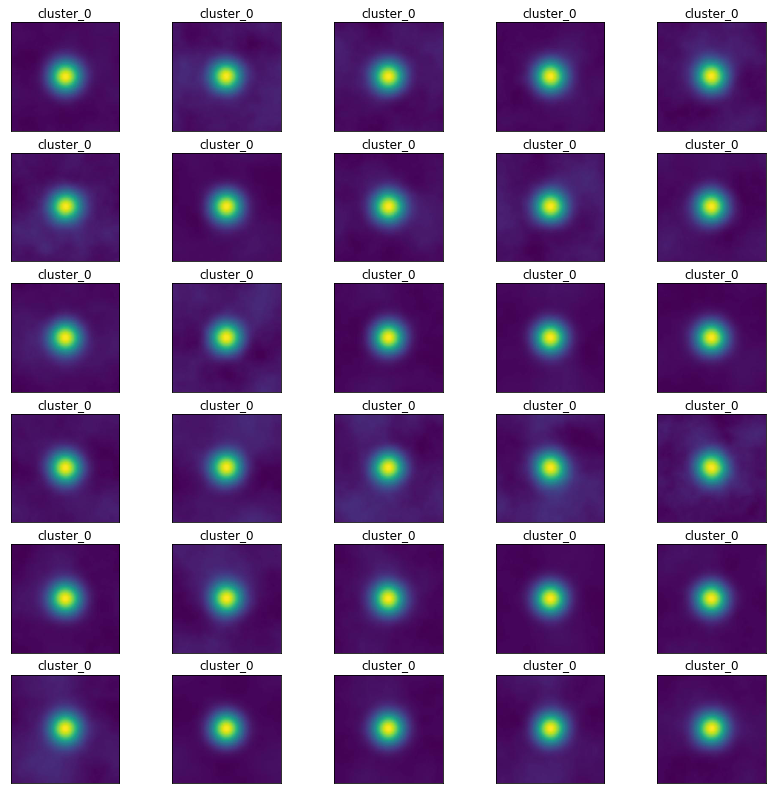

In [38]:
fig = plt.figure(figsize=(14, 14))

cluster_path = '/Users/hewyu/Downloads/Clustering EHT images/cluster_0/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[0:99]):
#     print(data)
    y = fig.add_subplot(6, 5, cnt+1)
    img = mpimg.imread(cluster_path+data)
    y.imshow(img)
    plt.title('cluster_0')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

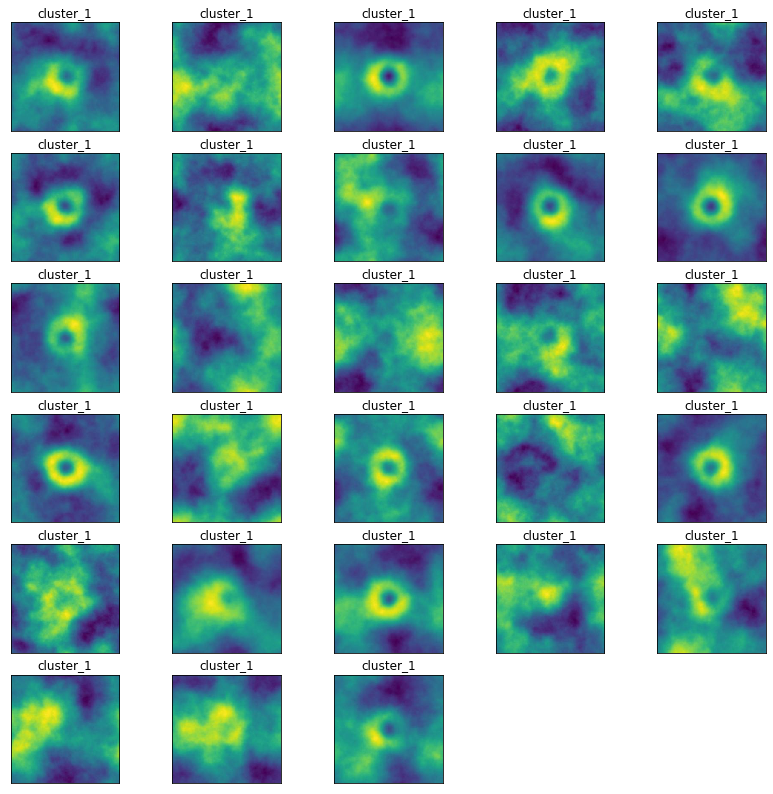

In [39]:
fig = plt.figure(figsize=(14, 14))

cluster_path = '/Users/hewyu/Downloads/Clustering EHT images/cluster_1/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[0:99]):
#     print(data)
    y = fig.add_subplot(6, 5, cnt+1)
    img = mpimg.imread(cluster_path+data)
    y.imshow(img)
    plt.title('cluster_1')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

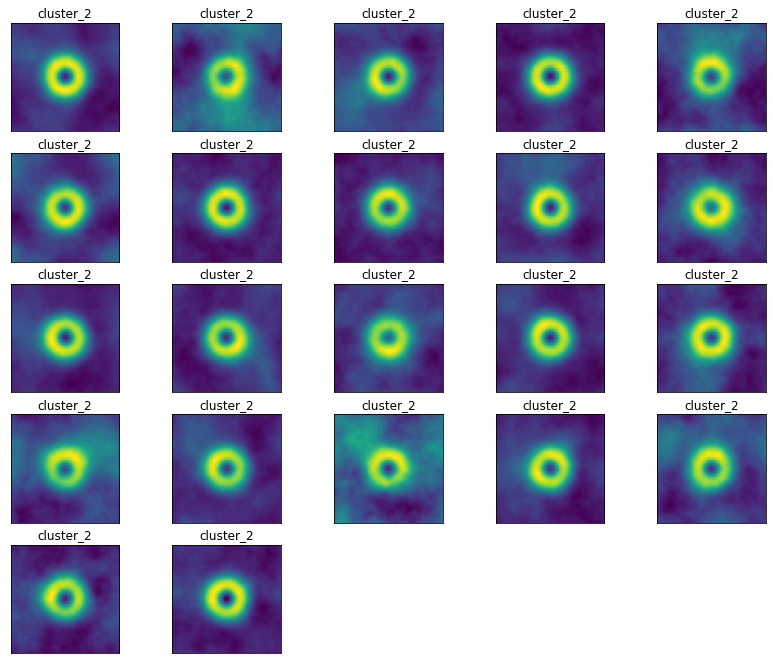

In [40]:
fig = plt.figure(figsize=(14, 14))

cluster_path = '/Users/hewyu/Downloads/Clustering EHT images/cluster_2/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[0:99]):
#     print(data)
    y = fig.add_subplot(6, 5, cnt+1)
    img = mpimg.imread(cluster_path+data)
    y.imshow(img)
    plt.title('cluster_2')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

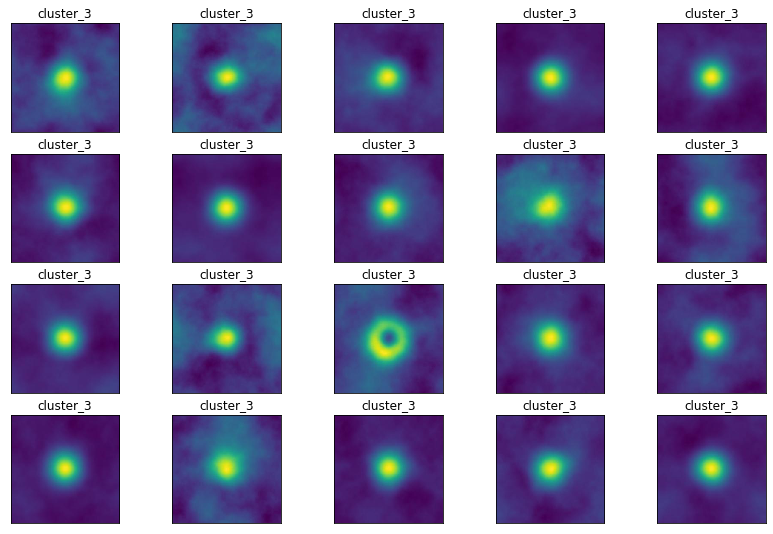

In [41]:
fig = plt.figure(figsize=(14, 14))

cluster_path = '/Users/hewyu/Downloads/Clustering EHT images/cluster_3/'
images = [file for file in os.listdir(cluster_path)]

for cnt, data in enumerate(images[0:99]):
#     print(data)
    y = fig.add_subplot(6, 5, cnt+1)
    img = mpimg.imread(cluster_path+data)
    y.imshow(img)
    plt.title('cluster_3')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)